# CBoW(Continuous Bag of Words)
- 주변 단어(Context Word)로 중심 단어(Center Word, target)를 예측하는 방법
- 윈도우(Window): 중심 단어를 맞추기 위해 몇개의 주변 단어를 고려할지 정하는 범위
- 슬라이딩 윈도우(Sliding Window): 학습을 위해 윈도우를 이동하면서 학습하는 방법

![CBoW Model](../assets/img/nlp/3-Word2Vec-CBoW.png)

## 모델
### 1)입력층
- 윈도우(맥락 단어의 개수)가 2개인 경우 입력레이어 2개를 은닉층과 완전연결계층으로 연결
- 가중치 W_in : 단어의 `분산 표현`-> 학습하면서 target단어를 잘 예측할 수 있도록 분산 표현이 갱신
  
### 2)은닉층
- 입력층이 여러개인 경우 전체의 `평균`으로 구함
- 입력층의 단어의 개수보다 은닉층 뉴런의 개수가 적어야 함 
  > 단어 예측에 필요한 정보를 간결하게 얻을 수 있음 <br>
  > 결과적으로 희소벡터가 아닌 밀집 벡터 표현을 얻을 수 있음.

### 3)출력층
- 출력층 뉴런의 개수: 단어의 개수와 동일
- softmax함수를 사용하여 각 단어가 target일 확률로 변환

## embedding


## 코딩
- https://github.com/rickiepark/nlp-with-pytorch/blob/main/chapter_5/5_2_CBOW/5_2_Continuous_Bag_of_Words_CBOW.ipynb 참고
### 1. data
- dataset : http://bit.ly/2T5iU8J 에서 메리 셸리의 소설 [프랑켄슈타인]의 디지털 버전을 받아 구축한 텍스트 데이터셋 활용

In [29]:
import os
from argparse import Namespace
import collections
import nltk.data
import numpy as np
import pandas as pd
import re
import string
from  tqdm import tqdm

In [30]:

args = Namespace(
    raw_dataset_txt = "../assets/data/nlp/3_Word2Vec_CBoW_frankenstein.txt",
    window_size = 5,
    train_proportion = 0.7,
    val_proportion = 0.15,
    test_proportion = 0.15,
    output_munged_csv="../assets/data/nlp/3_Word2Vec_CBoW_frankenstein_with_splits.csv",
    seed=42
)


####  1) data preprocessing

In [31]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shiney\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
# Split the raw text into sentences
tokenizer =nltk.data.load('tokenizers/punkt/english.pickle')

with open(args.raw_dataset_txt, encoding = 'UTF8') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)

print(len(sentences))
print("sample: ", sentences[100])

3206
sample:  I dare not expect such success, yet I cannot bear to look on the reverse of the picture.


In [33]:
# clean sentences
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

cleaned_sentences = [preprocess_text(sentence) for sentence in sentences]

num = 1100
print("before cleaning: ", sentences[num])
print("after cleaning: ", cleaned_sentences[num])

before cleaning:  Again shall you raise the funeral wail, and the sound of your lamentations shall again and again be heard!
after cleaning:  again shall you raise the funeral wail , and the sound of your lamentations shall again and again be heard ! 


#### 2) CBow dataset 만들기 

In [34]:
# Global vars
MASK_TOKEN = "<MASK>"

# Create windows
flatten = lambda outer_list: [item for inner_list in outer_list for item in inner_list]
windows = flatten([list(nltk.ngrams([MASK_TOKEN] * args.window_size + sentence.split(' ') + \
    [MASK_TOKEN] * args.window_size, args.window_size * 2 + 1)) \
    for sentence in tqdm(cleaned_sentences)])


print(len(cleaned_sentences) ,'-> ',len(windows))
print('sample:', windows[0])

100%|██████████| 3206/3206 [00:00<00:00, 54484.50it/s]

3206 ->  90570
sample: ('<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', 'the', 'project', 'gutenberg', 'ebook', 'of', 'frankenstein')


In [35]:
data = []

for window in tqdm(windows):
    target_token = window[args.window_size]
    context = []
    for i, token in enumerate(window):
        if token == MASK_TOKEN or i == args.window_size:
            continue
        else:
            context.append(token)
    data.append([' '.join(token for token in context),target_token])

print(len(data))
print(data[0])
print(data[1])

100%|██████████| 90570/90570 [00:00<00:00, 180228.35it/s]


90570
['project gutenberg ebook of frankenstein', 'the']
['the gutenberg ebook of frankenstein ,', 'project']


In [36]:
# dataframe
cbow_data = pd.DataFrame(data, columns = ['context', 'target'])

cbow_data.head()

,context,target
0,project gutenberg ebook of frankenstein,the
1,"the gutenberg ebook of frankenstein ,",project
2,"the project ebook of frankenstein , by",gutenberg
3,"the project gutenberg of frankenstein , by mary",ebook
4,"the project gutenberg ebook frankenstein , by ...",of


In [37]:
# split train, test, val
n = len(cbow_data)

def get_split(row_num):
    if row_num <= n * args.train_proportion:
        return 'train'
    elif (row_num > n * args.train_proportion) and (row_num <= n *  args.train_proportion + n * args.val_proportion):
        return 'val'
    else:
        return 'test'

cbow_data['split'] = cbow_data.apply(lambda row: get_split(row.name), axis = 1)

cbow_data.tail()


,context,target,split
90565,our email newsletter to hear new ebooks .,about,test
90566,email newsletter to hear about ebooks .,new,test
90567,newsletter to hear about new .,ebooks,test
90568,to hear about new ebooks,.,test
90569,hear about new ebooks .,,test


In [38]:
# Write split data to file
cbow_data.to_csv(args.output_munged_csv, index=False)

## 2. Vocabulary, Vectorizer, DataLoader 클래스
- 텍스트 입력을 벡터의 미니배치로 바꾸기
> 1. 토큰을 정수로 매핑하기
> 2. 앞의 각 데이터 포인터에 적용해 벡터 형태로 변환-> 고정된 길이로(padding 이용)
> 3. 벡터로 변환한 데이터 포인트를 미니배치로 모음 

In [39]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

### 1)  토큰을 정수로 매핑하기-> Vocabulary class

In [40]:
# Vocabulraty
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스"""

    def __init__(self, token_to_idx = None, mask_token = "<MASK>", add_unk = True, unk_token =">UNK>"):
        """
        매개변수:
            token_to_idx(dict) : 기존 토큰-인텍스 매핑 딕셔너리
            mask_token(str) : Vocabulary에 추가할 MASK 토큰
                            -> 모델 파라미터를 업데이트 하는데 사용하지 않는 위치를 나타냄
            add_unk(bool) : UNK 토큰을 추가할지 지정하는 플래그
            unk_token(str) : Vocabulary에 추가할 UNK 토큰
        """
        if token_to_idx is None:
            token_to_idx = {}
        
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx : token for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)

    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다."""
        return {'token_to_idx': self._token_to_idx,
                'add_unk': self._add_unk,
                'unk_token': self._unk_token,
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다"""
        return cls(**contents)

    def add_token(self, token):
        """토큰을 기반으로 매핑 딕셔너리를 업데이트합니다
        매개변수:
            token(str): Vocabulary에 추가할 토큰
        반환값:
            index(int): 토큰에 상응하는 정수
        """

        if token in self._token_to_idx:
            index = len(self._token_to_idx)
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.
        매개변수:
            token(list): 문자열 토큰 리스트
        반환값:
            indeces(list): 토큰 리스트에 상응하는 인텍스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응되는 인덱스를 추출합니다.  토큰이 없으면 UNK 인덱스를 반환합니다.
        매개변수:
            token(str): 찾을 토큰
        반환값:
            index(int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면(Vocavulary에 추가하기 위해) 'unk_index'가 0보다 커야 합니다
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다. 
        매개변수:
            index(int): 찾을 인덱스
        반환값:
            token(str): 인덱스에 해당하는 토큰
        에러:
            KeyError : 인덱스가 Vocabulary에 없을 때 발생합니다.
        """

        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)
    

### 2) 앞의 각 데이터 포인터에 적용해 벡터 형태로 변환


In [41]:
class CBOWVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다."""
    def __init__(self, cbow_vocab):
        """ 
        매개변수:
            cbow_vocab(Vocabulary) : 단어에 정수를 매핑합니다.
        """

        self.cbow_vocab = cbow_vocab
    def vectorize(self, context, vector_length = -1):
        """ 
        매개변수:
            context(str) : 공백으로 나누어진 단어 문자열
            vector_length(int) : 인덱스 벡터의 길이 매개변수
        """

        indices = [self.cbow_vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype = np.int64)
        out_vector[:len(indices)] = indices 
        out_vector[len(indices):] = self.cbow_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, cbow_df):
        """ 데이터셋 데이터프레임에서 Vectorizer 객체를 만듭니다
        
        매개변수:
            cbow_df(pandas.DataFrame) : 타깃 데이터셋
        반환값:
            CBOWVectorizer 객체
        """
        cbow_vocab = Vocabulary()
        for index, row in cbow_df.iterrows():
            for token in row.context.split(' '):
                cbow_vocab.add_token(token)
            cbow_vocab.add_token(row.target)

        return cls(cbow_vocab)

    @classmethod
    def from_serializable(cls, contents):
        cbow_vocab = Vocabulary.from_serializagle(contents['cbow_vocab'])
        return cls(cbow_vocab = cbow_vocab)

    def to_serializable(self):
        return {'cbow_vocab': self.cbow_vocab.to_serializable()}   

### 3)  벡터로 변환한 데이터 포인트를 미니배치로 모음  



- CBOWDataset

In [42]:
class CBOWDataset(Dataset):
    def __init__(self, cbow_df, vectorizer):
        """ 
        매개변수:
            cbow_df(pandas.DataFrame) : 데이터셋
            vectorizer(CBOWVectorizer) : 데이터셋에서 만든 CBOWVectorizer 객체
        """

        self.cbow_df = cbow_df
        self._vectorizer = vectorizer

        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, cbow_df.context))

        self.train_df = self.cbow_df[self.cbow_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.cbow_df[self.cbow_df.split=='val']
        self.val_size = len(self.val_df)

        self.test_df = self.cbow_df[self.cbow_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_df), }

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, cbow_csv):
        """ 데이터셋을 로드하고 처음부터 새로운 Vectorizer 만들기
        매개변수:
            cbow_csv(str) : 데이터셋의 위치
        반환값:
            CBOWDataset의 인스턴스
        """
        cbow_df = pd.read_csv(cbow_csv)
        train_cbow_df = cbow_df[cbow_df.split =="train"] 
        return cls(cbow_df, CBOWVectorizer.from_dataframe(train_cbow_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, cbow_csv, vectorizer_filepath):
        """ 데이터셋을 로드하고 새로운 CBOWVectorizer 객체를 만듭니다.
        캐시뒨 CBOWVectorizer 객체를 재사용할 때 사용합니다.
        매개변수:
            cbow_csv(str) : 데이셋의 위치
            vectorizer_filepath(str) : CBOWVectorizer 객체의 저장 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """
        cbow_df = pd.readcsv(cbow_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(cbow_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """ 파일에서 CBOWVectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer-filepath(str) : 직렬화된 CBOWVectorizer 객체의 위치
        반환값:
            CBOWVectorizer의 인스턴스
        """

        with open(vectorizer_filepath) as fp:
            return CBOWVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self,vectorizer_filepath):
        """ CBOWVectorizer 객체를 json형태로 디스트에 저장합니다.
        매개변수:
            vectorizer_filepath(str) : CBOWVectorizer 객체의저장 위치
        """
        with open(vectorizer_filepath,'w') as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다"""
        return self._vectorizer

    def set_split(self, split = 'train'):
        """ 데이터프레임에 있는 열을 사용해 분할 세트를 선택합니다."""
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index) :
        """ 파이토피 데이터셋의 주요 진입 메서트
        매개변수:
            index(int) : 데이터 포인트의 인덱스
        반환값:
            데이터포이트의 특성(x_data)과 레이블(y_target)로 이루어진 딕셔너리
        """
        row = self._target_df.iloc[index]

        context_vector = self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.cbow_vocab.lookup_token(row.target)

        return {'x_data': context_vector,
                'y_target': target_index}

    def get_num_batches(self, batch_size):
        """ 배치 크기가 주어지면 데이터셋으로 만들수있는 배치 개수를 반환합니다.
        
        매개변수:
            batch_size(int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle = True, drop_last = True, device = 'cpu'):
    """ 파이토치 DataLoader를 감싸고 있는 제너레이터 함수.
    각 텐서를 지정된 장치로 이동합니다.
    """
    dataloader = DataLoader(dataset = dataset,
                            batch_size = batch_size,
                            shuffle = shuffle,
                            drop_last = drop_last)

    for data_dict in dataloader:
        out_data_dict ={}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict



## 3. CBOWClassifier 모델

- 과정
> 1. Embedding층을 사용해 문맥의 단어를 나타내는 인텍스를 각 단어에 대한 벡터로 만들기
> 2. 전반적인 문맥을 감지하도록 벡터 결합
> 3. Linear층에서 문맥 벡터를 사용해 예측 벡터 계산-> 예측 벡터: 전체 어휘 사전에 대한 확률 분포 

In [43]:
class CBOWClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, padding_idx = 0):
        """ 
        매개변수: 
            vocabulary_size(int) : 어휘 사전 크기, 임베딩 개수와 예측 벡터 크기를 결정
            embedding_size(int): 임베딩 크기
            padding_idx(int): 기본값 0, 임베딩은 이 인덱스를 사용하지 않습니다.
        """
        super(CBOWClassifier, self).__init__()

        self.embedding = nn.Embedding(num_embeddings = vocabulary_size,  # 6173 -> 닥셔너리 개수
                                        embedding_dim = embedding_size,  # 300-> 은닉층 hidden node 개수
                                        padding_idx = padding_idx
                                    ) 
        self.fc1 = nn.Linear(in_features = embedding_size,
                            out_features= vocabulary_size) # 6173

    def forward(self, x_in, apply_softmax = False):
        """ 분류기의 정방향 계산
        
        매개변수:
            x_in(torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)입니다
            apply_softmax(bool): 소프트맥스 활성화 함수를 위한 플래그
                크로스 엔트로피 손신을 사용하려면 False로 지정합니다.
        반환값:
            결과 텐서.tensor.shape는 (batch, output_dim)입니다
        """
        x_embedded_sum = self.embedding(x_in).sum(dim =1)   # 문맥 단어 10개의 embedding값을 합치기
        y_out = self.fc1(x_embedded_sum)

        if apply_softmax:
            y_out = F.softmax(y_out, dim = 1)

        return y_out

        

## 4. train

- 과정
> 1. dataset, Vectorizer 객체, 모델, 손실함수, 옵티마이저 초기화
> 2.특정 에포크 횟수 동안 훈련 세트와 검증 셋트 반복
> 3. 훈련 세트로 손실함수를 최적화하고, 검증 세트로 훈련 과정을 평가 

#### 0) 헬퍼함수

In [44]:

def update_train_state(args, model, train_state):
    """ 훈련 상태를 업데이트합니다
    
    Components:
    - 조기 종료: 과대적합 방지
    - 모델 체크포인트: 더 나은 모델을 저장합니다.
    
    : param args: 메일 매개변수
    : param model: 훈련할 모델
    : param train_state: 훈련 상태를 담은 딕셔너리
    : return:
        새로운 훈련 상태
    """

    # 적어도 한번 모델을 저장합니다.
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    
    # 성능이 향상되면 모델을 저장합니다.
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 손실이 나빠지면
        if loss_t >= train_state['early_stopping_best_val']:
            # 조기종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # 조기 종료 단계 재 설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indeces = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indeces, y_target).sum().item()
    return n_correct/ len(y_pred_indeces) * 100

# 일반 유틸리티
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)


In [45]:
import torch.optim as optim

### 0. 설정

In [46]:
args = Namespace(
    # 날짜와 경로 정보
    cbow_csv = "../assets/data/nlp/3_Word2Vec_CBoW_frankenstein_with_splits.csv",
    vectorizer_file = "cbow_vectorizer.json",
    model_state_file = "cbow_model.pth",
    save_dir = "../assets/model/nlp/cbow",

    # 모델 하이퍼파라미터
    embedding_size = 300,

    # 훈련 하이퍼파라미터
    seed =42,
    num_epochs = 100,
    learning_rate = 0.001,
    batch_size = 128,
    early_stopping_criteria = 5,

    # 실행 옵션
    cuda = True,
    catch_keyboard_interrupt = True,
    reload_from_files = False,
    expand_filepaths_to_save_dir = True,
    device = 'cpu'
)

In [47]:


# train_state = make_train_state(args)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)

print('파일 경로:')
print('\t{}'.format(args.vectorizer_file))
print('\t{}'.format(args.model_state_file))


# CUDA check
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device('cuda' if args.cuda else 'cpu')
print("CUDA 사용여부: {}".format(args.cuda))

# 재현성을 위한 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)


파일 경로:
	../assets/model/nlp/cbow\cbow_vectorizer.json
	../assets/model/nlp/cbow\cbow_model.pth
CUDA 사용여부: True


### 1) 데이터셋, 모델, 소실, 옵티마이저, 훈련 상태 딕셔너리 만들기


In [48]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss':[],
            'val_acc': [],
            'test_loss' : -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

train_state = make_train_state(args)

# dataset, Vectorizer
if args.reload_from_files:
    print('데이터셋과 vectorizer를 로드합니다')
    dataset = CBOWDataset.load_dataset_and_load_vectorizer(args.cbow_csv, args.vectorizer_file)

else:
    print('데이터셋을 로드하고 vectorizer를 만듭니다')
    dataset = CBOWDataset.load_dataset_and_make_vectorizer(args.cbow_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

# model
classifier = CBOWClassifier(vocabulary_size= len(vectorizer.cbow_vocab),
                            embedding_size = args.embedding_size)
classifier = classifier.to(args.device)


# loss function, optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr = args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,
                                                mode = 'min',
                                                factor = 0.5,
                                                patience = 1)



데이터셋을 로드하고 vectorizer를 만듭니다


In [49]:
# vectorizer 확인
idx = list(range(0,10))
print([vectorizer.cbow_vocab.lookup_index(i) for i in idx])

['<MASK>', '>UNK>', 'project', 'gutenberg', 'ebook', 'of', 'frankenstein', 'the', ',', 'by']


In [50]:
# cbow_vocab 확인
print('vocabulary_size', len(vectorizer.cbow_vocab))

print(vectorizer.cbow_vocab.to_serializable().keys())
token = 'frankenstein'
print( token,'의 idx:', vectorizer.cbow_vocab.to_serializable()['token_to_idx'][token])

vocabulary_size 6173
dict_keys(['token_to_idx', 'add_unk', 'unk_token', 'mask_token'])
frankenstein 의 idx: 6


In [62]:
# model 확인
print(classifier)
# 6173 : vocabulary_size
# 300 : embedding_size

CBOWClassifier(
  (embedding): Embedding(6173, 300, padding_idx=0)
  (fc1): Linear(in_features=300, out_features=6173, bias=True)
)


### 2) 훈련

In [52]:
epoch_bar = tqdm(desc = 'training_routine',
                                total = args.num_epochs,
                                position = 0)

dataset.set_split('train')
train_bar = tqdm(desc = 'split = train',
                                total = dataset.get_num_batches(args.batch_size),
                                position = 1,
                                leave = True)

dataset.set_split('val')
val_bar = tqdm(desc = 'split = val',
                                total = dataset.get_num_batches(args.batch_size),
                                position = 1,
                                leave = True)
                                                   

split = val:   0%|          | 0/106 [00:34<?, ?it/s]


In [61]:
# input 값 확인
# 문맥단어가 5이기 때문에 5 * 2 = 10개의 단어가 input이 됨
dataset.set_split('train')
batch_generator = generate_batches(dataset,
                                    batch_size = args.batch_size,
                                    device = args.device)

running_loss = 0.0
running_acc = 0.0
classifier.train()

for batch_index, batch_dict in enumerate(batch_generator):
    print(batch_dict['x_data'].shape)
    if batch_index == 0:
        data = batch_dict['x_data'][0]
        data_idx = data.tolist()
        print(data_idx)

        token = [vectorizer.cbow_vocab._idx_to_token[i] for i in data_idx]
        print(len(token), token)

    break

torch.Size([128, 10])
[2738, 293, 399, 650, 5, 4349, 8, 7, 1805, 5]
10 ['views', 'he', 'had', 'taken', 'of', 'society', ',', 'the', 'means', 'of']


In [63]:
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회
        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_batches(dataset,
                                            batch_size = args.batch_size,
                                            device = args.device)

        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정
            # --------------------------------------------
            # 단계 1. 그레디언트를 0으로 초기화
            optimizer.zero_grad()

            # 단계 2. 출력을 계산
            y_pred = classifier(x_in = batch_dict['x_data'])

            # 단계 3. 손실을 계산
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss)/(batch_index + 1)

            # 단계 4. 손실을 사용해 그레이디언트 계산
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트
            optimizer.step()
            # --------------------------------------------

            # 정확도 계산
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행바 업데이트
            train_bar.set_postfix(loss = running_loss,
                                    acc = running_acc,
                                    epoch = epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회
        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_batches(dataset,
                                            batch_size = args.batch_size,
                                            device = args.device)

        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 검증 과정
            # --------------------------------------------
            # 단계 1. 출력을 계산
            y_pred = classifier(x_in = batch_dict['x_data'])

            # 단계 2. 손실을 계산
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss)/(batch_index + 1)

            # 단계 3. 정확도 계산
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            # --------------------------------------------

            # 진행바 업데이트
            val_bar.set_postfix(loss = running_loss,
                                    acc = running_acc,
                                    epoch = epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args = args,
                                        model = classifier,
                                        train_state = train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print('Exiting loop')


training_routine: 100%|██████████| 100/100 [33:00<00:00, 10.68s/it]  

### 3) 결과

In [70]:
from matplotlib.pylab  import plt
from numpy import arange

train 100
val 100


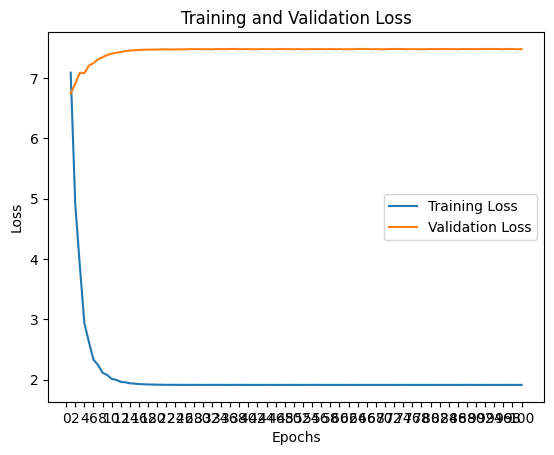

In [76]:
# train_loss, val_loss 비교
train_loss = train_state['train_loss']
val_loss = train_state['val_loss']

print('train', len(train_loss))
print('val', len(val_loss))

 
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, 101)
 
# Plot and label the training and validation loss values
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 101, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()



In [77]:
# 가장 좋은 모델을 사용헤 테스트 세트의 손실과 정확도 계산
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()


dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # 출력을 계산합니다
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # 손실을 계산합니다
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # 정확도를 계산합니다
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

TypeError: 'DataFrame' object cannot be interpreted as an integer

In [65]:
print('test set loss: {}'.format(train_state['test_loss']))
print('test_set acc: {}'.format(train_state['test_acc']))

test set loss: -1
test_set acc: -1


### 4) embedding 확인

In [78]:
def pretty_print(results):
    """ 
    임베딩 결과를 출력합니다
    """
    for item in results:
        print("...[%.2f] - %s"%(item[1], item[0]))

def get_closest(target_word, word_to_idx, embeddings, n =5):
    """
    n개의 최근접 단어를 찾습니다.
    """

    # 다른 모든 단어와의 거리를 계산합니다
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append(word, torch.dist(word_embedding, embeddings[index]))

    results = sorted(distances, key = lambda x: x[1])[1:n+2]
    return results

In [79]:
word = '왕'
embeddings = classifier.embedidng.weight.data
word_to_idx = vectorizer.cbow_vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n = 5))

- embedding 값은 세가지 모두 될 수 있음.
  > - 입력층의 가중치
  > - 출력층의 가중치
  > - 양쪽 가중치 모두 이용

- Word2Vec 모델(특히 skip-gram)에서는 입력층의 가중치를 많이 사용
- GloVe 모델에서는 두 가중치를 더해서 사용

##### Reference
- 밑바닥부터 시작하는 딥러닝2
- 파이토치로 배우는 자연어 처리 (한빛미디어, )